## Using the C12 emulator
<b>C12</b> Callisto is software that emulates our real quantum machine in development.
It is made on top of the Qiskit library with a proprietary noise model corresponding to our system and with the physical parameters of real devices.
This offers realistic noisy simulations of runs on real devices.
All the errors that occur during the execution of a quantum circuit have been modelled in the emulator.

Quantum errors are due to decoherence channels.
This first version includes decoherence from charge noise, from phonon noise and from relaxation of the qubit through its quantum bus, a microwave resonator.
Callisto offers additional features like mid-circuit measurement and noisy initialization.
The quantum gate set of the current configuration is $R_X$, $R_Y$ and $R_Z$ for the 1Q gates and ISWAP for the 2Q gate.
Any other gate will be transpiled into this basis gate set.

Callisto's physical parameters are based on the first quantum chip that <b>C12</b> will fabricate & release.
For the moment, we offer one fixed configuration of the <b>C12</b> emulator.
The chosen configuration leads to the following fidelities.

### Running a quantum circuit
To run the circuits on the C12 emulator, first, it is mandatory to obtain the authentication token that will be used for connection to the remote server where our emulator is. So don't hesitate to contact the system administrator to get one.

A token is set via UserConfig class, as shown in the example bellow. UserConfig class has other properties, like more detailed out, which can be set by setting the parameter "verbose" to True. One important remark is that the object of the `UserConfig` class is passed to the provider instance, so for any change to take effect one has to reinitialize the provider.


As mentioned in the first tutorial, the provided class contains information about available backends that can be used for running the circuit. Furthermore, the available ones can be viewed using the `backends()` method of the provider class (recall that this applies to every Qiskit's provider class, as its sole purpose is to provide access to backends).



In [2]:
# UserConfig class
from c12_callisto_clients.user_configs import UserConfigs
import os
user_auth_token = os.getenv("C12_TOKEN")
configs = UserConfigs.parse_obj({"token" : user_auth_token})

from c12_callisto_clients.qiskit.c12sim_provider import C12SimProvider
c12_simulator_provider = C12SimProvider(configs)
c12_backends = c12_simulator_provider.backends()


print(f"Backend data {c12_backends[0]}")


Backend data {'backend_name': 'c12sim', 'local': False, 'simulator': True, 'basis_gates': ['crx', 'rx', 'ry', 'rz'], 'description': 'C12 simulator', 'n_qubits': 13, 'conditional': False, 'max_shots': 100000, 'memory': False, 'open_pulse': False, 'max-circuits': 10}


We have to call the `get_backend()` function to get the instance of a chosen backend. To the `get_backend()` function, we pass the name of the desired backend we need to obtain.

In [3]:
c12_simulator_backend_iswap = c12_simulator_provider.get_backend('c12sim-iswap')  # Basis gate set with iSWAP gate
print(c12_simulator_backend_iswap)

Finally, we will run a quantum circuit on the C12 simulator. We will create one circuit using the Qiskit QuantumCircuit class to do that. Then, using the obtained C12 simulator backend class, we will run the circuit using the `run()` method.

Method `run()` can have an additional parameter, such as the number of shots (number of times the simulation is run).
Also, recall that after calling the `run()` method, we get an instance of a Job class.
Additionally, it could take some time for the simulation to finish. Usually, the time is less than one minute, but it depends on the circuit and the server load at that moment.

Furthermore, in the sixth notebook it is shown that we can pass physical parameters to the `run()` method in order to run the simulation with different physical system.

In [4]:
from qiskit import QuantumCircuit

circuit = QuantumCircuit(2)
circuit.h(0)
circuit.cx(0, 1)

c12_job_iswap = c12_simulator_backend_iswap.run(circuit, shots=10000)
c12_result_iswap = c12_job_iswap.result()
c12_counts_iswap = c12_result_iswap.get_counts()
print(f"C12 simulation counts (iSWAP): {c12_counts_iswap}")

C12 simulation counts (iSWAP): {'00': 5040, '01': 11, '10': 10, '11': 4939}


In [6]:
# We will also run the same circuit on the Aer statevector simulator to obtain the perfect results.
from qiskit_aer import AerSimulator

circuit.measure_all()
backend_aer = AerSimulator()
result_aer = backend_aer.run(circuit, shots=10000).result()
counts_aer = result_aer.get_counts()

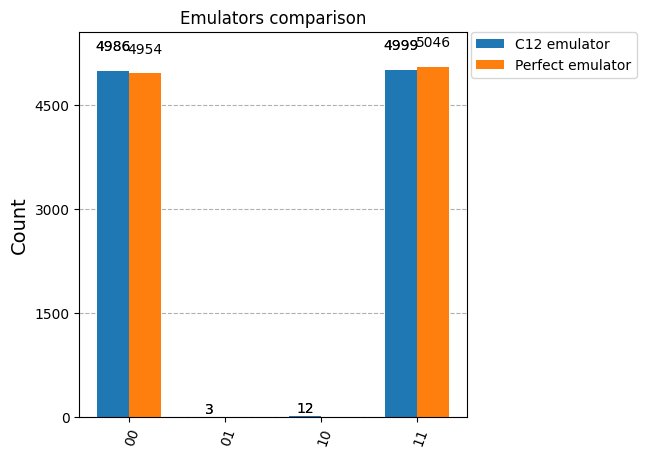

In [7]:
# Make comparison
from qiskit.visualization import plot_histogram
iswap = {}
for key, value in c12_counts_iswap.items():
    iswap[key.strip()] = value
data = [iswap, counts_aer]
plot_histogram(data,
               legend=['C12 emulator', 'Perfect emulator'],
               title="Emulators comparison",
               figsize=(5, 5))

### Grover algorithm example

The Grover algorithm, also known as Grover's search algorithm, is a quantum algorithm that can be used to search an unsorted database or find a specific database entry faster than classical algorithms. It is one of the earliest quantum algorithms.

The algorithm works by starting with a superposition of all possible states and then applying a series of operations to amplify the amplitude of the state corresponding to the desired item. As a result, the algorithm achieves a quadratic speedup over classical algorithms, which means that it can search a database of N items in O($\sqrt{N}$) time, compared to O(N) time for classical algorithms.

First, we will create an groover circuit with a two qubits.

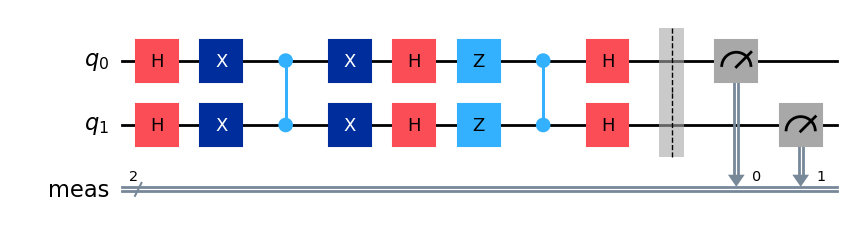

In [9]:
from qiskit import QuantumRegister

qreg_q = QuantumRegister(2, 'q')
groover_circuit = QuantumCircuit(qreg_q)

groover_circuit.h(qreg_q[1])
groover_circuit.h(qreg_q[0])
groover_circuit.x(qreg_q[1])
groover_circuit.x(qreg_q[0])
groover_circuit.cz(qreg_q[0], qreg_q[1])
groover_circuit.x(qreg_q[0])
groover_circuit.x(qreg_q[1])
groover_circuit.h(qreg_q[0])
groover_circuit.h(qreg_q[1])
groover_circuit.z(qreg_q[0])
groover_circuit.z(qreg_q[1])
groover_circuit.cz(qreg_q[0], qreg_q[1])
groover_circuit.h(qreg_q[0])
groover_circuit.h(qreg_q[1])
groover_circuit.measure_all()
groover_circuit.draw('mpl')

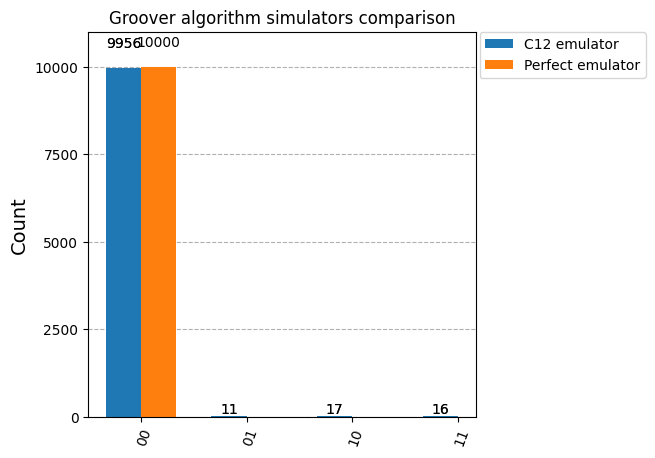

In [10]:
# Run the circuit on C12 simulator
c12_groover_result = c12_simulator_backend_iswap.run(groover_circuit, shots=10000).result()
c12_groover_counts = c12_groover_result.get_counts()

iswap = {}
for key, value in c12_groover_counts.items():
    iswap[key.strip()] = value

aer_groover_result = backend_aer.run(groover_circuit, shots=10000).result()
aer_groover_counts = aer_groover_result.get_counts()

data = [iswap, aer_groover_counts]
plot_histogram(data, legend=['C12 emulator', 'Perfect emulator'], title="Groover algorithm simulators comparison", figsize=(5,5))